# Load Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FPATH='drive/My Drive/DATA/1096'
RESULT_PATH='drive/My Drive/Results_1096/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
def dir_filenames(dir):
    list_of_files = []
    for (dirpath, dirnames, filenames) in os.walk(dir):
        for filename in filenames:
            list_of_files.append(os.sep.join([dirpath, filename]))
    #list_of_files = [x for x in list_of_files if 'Copy' in x]
    return list_of_files
def load_new_ii_dataset():
    ss_path=f'{FPATH}/interictal_data'
    list_of_files = dir_filenames(ss_path)
    return np.vstack([np.load(f) for f in list_of_files])

# Preprocessing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import SelectKBest
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
feature_name='se_ss_5000'
# stds, means = np.load(f"{FPATH}/stds.npy"), np.load(f"{FPATH}/means.npy")
def zscore(X):
    return (X - means.T) / stds.T
def normalize(X):
    stats=np.load(f"{FPATH}/stats.npy")
    mean = stats[:,1]
    mean = mean.reshape((1, X.shape[1]))
    std = stats[:,2]
    std = std.reshape((1, X.shape[1]))
    return (X-mean)/std

In [ ]:
def save_results(results_dict, r, k):
    for measure, values in results_dict.items():
        np.save(f"{RESULT_PATH}Iso_{measure}_{r:.1f}_{k}.npy", values)
        print(f"Trial: {k}, % Anom:{r}, {measure}:{np.mean(values)}")

def calc_FPR(y_pred):
    cool_off_period = 1536*1 # 5 min
    i = 0
    new_preds = np.zeros(y_pred.shape[0])
    while i < new_preds.shape[0]:
        new_preds[i] = y_pred[i]
        if y_pred[i] == 1:
            i += cool_off_period
        else:
            i += 1
    return new_preds.sum()
def calc_performance(y_pred_0, y_pred_1):
    FP = (y_pred_0==1).sum() # calc_FPR(y_pred_0)
    lat = y_pred_1.shape[0] if 1 not in y_pred_1 else list(y_pred_1).index(1)
    sens = 1 if 1 in y_pred_1 else 0
    acc = ((y_pred_0==0).sum()+(y_pred_1==1).sum())/(y_pred_0.shape[0]+y_pred_1.shape[0])
    print("N nsz:{}, N sz: {}, FP:{}, lat:{}, sens:{}, acc:{}".format(y_pred_0.shape[0],
          y_pred_1.shape[0],FP, lat, sens, acc))
    return FP, lat, sens, acc

def eval_classifier(clf,X,y,x0,x1, fold,r):
    if clf == 'knn':
        return run_knn(X,y,x0,x1)
    t=time.time()
    if clf == 'sgd':
        clf_ = SGDClassifier(loss='log').fit(X,y)
    else:
        clf_ = clf().fit(X,y)
    print(f"Trained in {time.time()-t}s. Now testing..")
    dump(clf_, RESULT_PATH+'lr_sgd_' + str(fold) + '_'+f'{r:.1f}.joblib')
    y0=clf_.predict(x0)
    y1=clf_.predict(x1)
    return calc_performance(y0,y1)

def predict_sample(neighbors, labels, k):
    return round(np.mean([labels[i] for i in neighbors[:k]]))

def run_knn(X, y, x_test_0, x_test_1):
    n_neighbors = 10
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(X, y)
    t=time.time()
    neighbors_0 = neigh.kneighbors(x_test_0, return_distance=False)
    neighbors_1 = neigh.kneighbors(x_test_1, return_distance=False)
    print("Done computing nn in {}s".format(time.time()-t))
    FP,latency,sens,acc = np.zeros(n_neighbors), np.zeros(n_neighbors), np.zeros(n_neighbors), np.zeros(n_neighbors)
    for k in range(n_neighbors):
        y_pred_0 = np.array([predict_sample(neighbors_0[i], y, k+1) for i in range(x_test_0.shape[0])])
        y_pred_1 = np.array([predict_sample(neighbors_1[i], y, k+1) for i in range(x_test_1.shape[0])])
        FP[k], latency[k], sens[k], acc[k] = calc_performance(y_pred_0, y_pred_1)
    #print("Avg FP:{}, lat:{}, sens:{}, acc:{}".format(np.mean(FP), np.mean(latency), np.mean(sens), np.mean(acc)))
    return FP[0], latency[0], sens[0], acc[0]

In [ ]:
from os import path
def select_fts(x_train, y_train, x_test_nsz, x_test_sz, k):
    if k == -1:
        return x_train, y_train, x_test_nsz, x_test_sz
    if k == 0:
        np.random.seed(4); idxs = np.random.choice(x_train.shape[1],15,replace=False)
        return x_train[:, idxs], y_train, x_test_nsz[:, idxs], x_test_sz[:, idxs]
    fs = SelectKBest(k=k).fit(x_train, y_train)
    x_train = fs.transform(x_train)
    indices = fs.get_support(indices=True)
    np.save(f"{FPATH}/top_features.npy", indices)
    x_test_sz, x_test_nsz = x_test_sz[:, indices], x_test_nsz[:, indices]
    return x_train, y_train, x_test_nsz, x_test_sz

def get_sz(sz_n):
    if path.isfile(sz_n):
        try:
            arr = np.load(sz_n)
            # if arr.shape[1] != 2580:
            #     print(f"File {sz_n} bad file")
            return arr
        except:
            print(f"File {sz_n} failed to load")
    if not path.isfile(f"{FPATH}/seizure_data/sz_{sz_n}.npy"):
        return np.load(f"{FPATH}/seizure_data/X_s_{sz_n}.npy")
    return np.load(f"{FPATH}/seizure_data/sz_{sz_n}.npy")

def get_fvs(db_id, idxs=None):
    if path.isfile(db_id):
        try:
            arr = np.load(db_id)
            # if arr.shape[1] != 3500:
            #     print(f"File {db_id} bad file")
            return arr
        except:
            print(f"File {db_id} failed to load")
    f1 = f"{FPATH}/interictal_data/intersz_{db_id}.npy"
    f2 = f"{FPATH}/interictal_data/se_ss_5000_{db_id}.npy"
    fpath = f1 if path.isfile(f1) else f2
    if idxs is not None:
        return np.load(fpath)[idxs, :]
    return np.load(fpath)

def sample_files(interictal, indices):
    indices_organized = np.array(indices)//5000
    current_idx = -1
    interictal_dataset = []
    temp = []
    for i,file_idx in enumerate(indices_organized):
        if file_idx!=current_idx:
            current_idx=file_idx
            temp = get_fvs(interictal[current_idx])
        offset_file = indices[i] % 5000
        interictal_dataset.append(temp[offset_file,:])
    interictal_dataset = np.array(interictal_dataset)
    return interictal_dataset

def random_indices(n_files, size, method):
    # np.random.seed(5)
    if method == 'DS-R':
        indices = np.sort(np.random.choice(a = n_files*5000, size=size, replace = False)) # Method 1
    else: # method == 'DS-N'
        step = n_files*5000//size
        limit = step*size
        indices = np.arange(0,limit,step) # Method 2
    return indices

def sample_interictal(interictal, train_size, test_size):
    total_size = train_size+test_size
    indices = random_indices(len(interictal), total_size, method='DS-R')
    interictal_dataset = sample_files(interictal, indices)
    if test_size == total_size or train_size == total_size:
        return interictal_dataset
    else:
        train_ii, test_ii = train_test_split(interictal_dataset, test_size=test_size)
    return train_ii, test_ii

def leave_out(list_, idx):
    return [list_[i] for i in range(len(list_)) if i != idx]

def load_anom(iso=True):
    if iso:
        return np.load(f"{RESULT_PATH}isoforest_outliers.npy")
        #return np.load(f"{FPATH}/isoforest_outliers.npy")
    return np.load(f"{FPATH}/anomaly_data/anom_fvs.npy")

def remove_test(ii, test):
    train_ii = [f for f in ii]
    if not isinstance(test, list):
        test = [test]
    for t in test:
        train_ii.remove(t)
    return train_ii

def get_train_test(train_ii, test_ii, train_sz, test_sz, pct_anom=0, anom=None):
    # features = np.arange(0,2550,34); # features = np.load('top_features.npy')
    x_train_sz = np.vstack([get_sz(j) for j in train_sz])
    x_test_sz = normalize(np.vstack([get_sz(j) for j in test_sz]))#[:, features]
    n_anom_ii, n_rand_ii = int(pct_anom*x_train_sz.shape[0]), int((1-pct_anom)*x_train_sz.shape[0])
    x_train_nsz = sample_interictal(train_ii, n_rand_ii, 0) # sample_interictal(intersz, n_rand_ii, x_test_sz.shape[0], method='DS-R')
    x_test_nsz = normalize(np.vstack([get_fvs(t) for t in test_ii]))
    if pct_anom > 0:
        anom = load_anom(); anom = np.vstack([anom, anom])
        rnd_idxs = np.sort(np.random.choice(a=anom.shape[0], size = min(anom.shape[0],n_anom_ii), replace = False))
        anom_ii = anom[rnd_idxs, :]
        if n_rand_ii == 0:
            x_train_nsz = anom_ii
        else:
            x_train_nsz = np.vstack([anom_ii, x_train_nsz])
    print(x_train_sz.shape, x_train_nsz.shape)
    x_train = normalize(np.vstack([x_train_nsz, x_train_sz]))
    y_train = np.concatenate([np.zeros(x_train_nsz.shape[0]), np.ones(x_train_sz.shape[0])])
    return select_fts(x_train, y_train, x_test_nsz, x_test_sz,k=-1)
    
from joblib import dump, load
def losoCV(clf, intersz, test_ii, ss_test_ii, sz_files, anom=None, r=0, k=75, sampler=None):
    fpr, lat, sens, acc = [], [], [], []
    n_folds = len(sz_files); step = len(sz_files)//n_folds
    for i in range(n_folds):
        start=time.time()
        test_sz = [sz_files[k] for k in np.arange(i*step,(i+1)*step)]
        test_interictal = [test_ii[k] for k in np.arange(i*step,(i+1)*step)]
        ss_test_interictal = [ss_test_ii[k] for k in np.arange(i*step,(i+1)*step)]
        train_sz = remove_test(sz_files, test_sz)
        train_ii = remove_test(intersz, ss_test_interictal)
        if sampler is not None:
            x_train, y_train, x_test_nsz, x_test_sz = centroid_downsample(intersz, test_ii, sz_files, i)   
            #  x_train, y_train, x_test_nsz, x_test_sz = sample_imblearn(sampler, intersz, sz_files, i)   
        else:
            x_train, y_train, x_test_nsz, x_test_sz = get_train_test(train_ii, test_interictal, train_sz, test_sz, pct_anom=r, anom=anom)
        print(f"Running fold {i}, train samples: {x_train.shape}")
        fp_,lat_,sens_,acc_ = eval_classifier(clf,x_train, y_train, x_test_nsz, x_test_sz, i, r)
        fp_ = fp_/step
        fpr.append(fp_); lat.append(lat_); sens.append(sens_); acc.append(acc_)
        print(f"Average FPR: {np.mean(fpr)}")
        print(f"Total time for fold: {time.time()-start}")
    return {'fpr': fpr, 'lat': lat, 'sens': sens, 'acc': acc}

def to_str(x):
    if isinstance(x, float):
        return f"{x:.3f}"
    else: 
        return str(x)

def run_trials(n_trials, params):
    """params: dict"""
    for t in n_trials:
        for p in params:
            result = losoCV(clf, nonsz_files, sz_files, anom=anom, params={p: params[p]})
            for measure, values in result.items():
                str_p = to_str(params[p])
                np.save(f"{fname}{measure}_{str_p}_{t}.npy", values)
                print(f"Trial: {t}, {p}: {str_p}, {measure}:{np.mean(values)}")
        print(f"Done trial {t}")

def test_samplers(clf, samplers, nonsz_files, sz_files, fname, n_trials):
    anom = load_anom()
    for k in range(n_trials):
        for s in samplers:
            result = losoCV(clf, nonsz_files, sz_files, anom=anom, sampler=samplers[s])
            for measure, values in result.items():
                np.save(f"{fname}{measure}_{s}_{k}.npy", values)
                print(f"Trial: {k}, sampler: {s}, {measure}:{np.mean(values)}")
        print("Done trial {}".format(k))
                              
def test_ratios(clf, ratios, nonsz_files, test_ii, ss_test_ii, sz_files, fname, n_trials, sampler=None):
    for k in n_trials:
        for r in ratios:
            result = losoCV(clf, nonsz_files, test_ii, ss_test_ii, sz_files, r=r, sampler=sampler)
            save_results(result, r, k)
        print("Done trial {}".format(k))

def test_n_ft(range_nft, nonsz_files, sz_files, fname):
    for n_ft in range_nft:
        result = loso(nonsz_files, sz_files, k=n_ft)
        for measure, values in result.items():
            np.save(fname+measure+"_{}.npy".format(n_ft), values)
            print("num features:{}, {}:{}".format(n_ft, measure, np.mean(values)) )
    print("Done.")

def run_loso(nonsz_files, sz_files, fname):
    result = loso(nonsz_files, sz_files)
    for measure, values in result.items():
        np.save(fname+measure+".npy", values)
        print("{}:{}".format(measure, np.mean(values)))
    print("Done.")

# KMeans Downsampling

In [ ]:
def label(n_0, n_1):
    return np.concatenate([np.zeros(n_0), np.ones(n_1)])
def feature_selection(X_ii, X_sz, test_nsz, test_sz, k=75):
    y = label(X_ii.shape[0], X_sz.shape[0])
    skb = SelectKBest(k=k).fit(np.vstack([X_ii, X_sz]), y)
    return skb.transform(X_ii), skb.transform(X_sz), skb.transform(test_nsz), skb.transform(test_sz)

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans
def centroid_downsample(ii_files, test_ii, sz_files, i):
    features = np.arange(0,2550,34); # np.load('drive/My Drive/DATA/1096/top_features.npy')
    train_ii = [x for x in ii_files]
    for test_file in test_ii:
        train_ii = remove_test(train_ii, test_file)
    #train_ii = remove_test(ii_files, test_ii[i])
    x_train_sz = zscore(np.vstack([get_sz(j) for j in leave_out(sz_files, i)]))[:, features]
    x_test_sz = zscore(get_sz(sz_files[i]))[:, features]
    x_test_nsz = zscore(get_fvs(test_ii[i]))[:, features]
    x_nsz = zscore(np.vstack([get_fvs(x) for x in train_ii]))[:, features]
    print(x_nsz.shape)
    t0 = time.time()
    km = MiniBatchKMeans(n_clusters=x_train_sz.shape[0]+3000, batch_size=1000, random_state=0, verbose=1).fit(x_nsz)
    print(f"Runtime: {(time.time()-t0)/60.}")
    x_train_nsz = km.cluster_centers_
    np.save(f"{FPATH}/centroids.npy", x_train_nsz)
    y_train = label(x_train_nsz.shape[0], x_train_sz.shape[0])
    return np.vstack([x_train_nsz, x_train_sz]), y_train, x_test_nsz, x_test_sz

# Testing % Anomaly (z-scored)

In [ ]:
ii_files = list(np.load(f"{FPATH}/interictal_data/db_ids.npy"))#[1:] 
# ii_test = np.random.choice(ii_files, size=10, replace=False); 
# sz_files = np.arange(10) # remove_test(np.arange(32), [12,13]) 
ii_test = [138, 35, 3, 29, 13, 27, 31, 112, 71]
sz_files = np.arange(9)
def load_ii_dataset():
    return zscore(np.vstack([get_fvs(x) for x in ii_files]))
def load_sz_dataset():
    return zscore(np.vstack([get_sz(i) for i in sz_files]))

In [ ]:
def generate_test_files(interictal_files, num):
    np.random.seed(0)
    test_files = np.random.choice(interictal_files, num, replace=False)
    return test_files

In [ ]:
FPATH = 'drive/My Drive/NewData/1096'
sz_files = dir_filenames(FPATH+'/ictal'); sz_files.sort()
ii_files = dir_filenames(FPATH+'/interictal_data')
ii_ss_test = generate_test_files(ii_files, len(sz_files))
#ii_names = ['pat_FR_1096_20090623_123939_se.npy', 'pat_FR_1096_20090623_233954_se.npy', 'pat_FR_1096_20090619_025420_se.npy', 'pat_FR_1096_20090621_210057_se.npy', 'pat_FR_1096_20090624_234450_se.npy', 'pat_FR_1096_20090624_174442_se.npy', 'pat_FR_1096_20090623_193948_se.npy', 'pat_FR_1096_20090622_124825_se.npy', 'pat_FR_1096_20090624_154440_se.npy']
ii_test = [FPATH+'/interictal_se/'+x[x.index('pat'):] for x in ii_ss_test]

In [ ]:
ratios = np.arange(0,0.996,0.10)
clf = 'sgd'
test_ratios(clf,ratios, ii_files, ii_test, ii_ss_test, sz_files, f"{RESULT_PATH}Iso_rnd_", n_trials=[2])

(24851, 3750) (24851, 3750)
Running fold 0, train samples: (49702, 3750)
Trained in 11.022548913955688s. Now testing..
N nsz:92160, N sz: 3112, FP:0, lat:1398, sens:1, acc:0.973308002351163
Average FPR: 0.0
Total time for fold: 307.9339511394501
(25047, 3750) (25047, 3750)
Running fold 1, train samples: (50094, 3750)
Trained in 8.921935796737671s. Now testing..
N nsz:92160, N sz: 2916, FP:0, lat:1042, sens:1, acc:0.988672220118642
Average FPR: 0.0
Total time for fold: 230.6014232635498
(24950, 3750) (24950, 3750)
Running fold 2, train samples: (49900, 3750)
Trained in 11.184549808502197s. Now testing..
N nsz:92160, N sz: 3013, FP:69, lat:560, sens:1, acc:0.9859624053040253
Average FPR: 23.0
Total time for fold: 237.84116315841675
(24852, 3750) (24852, 3750)
Running fold 3, train samples: (49704, 3750)
Trained in 9.01290488243103s. Now testing..
N nsz:92160, N sz: 3111, FP:0, lat:245, sens:1, acc:0.9964102402619894
Average FPR: 17.25
Total time for fold: 235.6022264957428
(23934, 3750) 

In [ ]:
ratios = np.arange(0.0,0.996,0.20)
clf = 'sgd'
test_ratios(clf,ratios, ii_files, ii_test, ii_ss_test, sz_files, f"{FPATH}/DATA/1096/LR/newIso", n_trials=[0]) #, sampler='centroid')

# Predictions

In [ ]:
def clf_predictions(trials=[0]):
    ii_test = [FPATH+'/interictal_se/'+x for x in ii_names]
    sz_test = dir_filenames(FPATH+'/ictal'); sz_test.sort()
    paths = dir_filenames(FPATH+'/Results/')
    ratios = np.array(["{0:.1f}".format(x) for x in np.arange(0,96,10)/100.])
    for k in trials:
        for i,r in enumerate(ratios):
            r_paths = [p for p in paths if ratios[i] in p]
            fpr, lat, sens, acc = [], [], [], []
            for fold in range(9):
                clf = load(r_paths[fold])
                x0,x1 = normalize(np.load(ii_test[fold])), normalize(np.load(sz_test[fold]))
                y0=clf.predict(x0)
                y1=clf.predict(x1)
                fp_,lat_,sens_,acc_ = calc_performance(y0,y1)
                fpr.append(fp_); lat.append(lat_); sens.append(sens_); acc.append(acc_)
            result = {'fpr': fpr, 'lat': lat, 'sens': sens, 'acc': acc}
            save_results(result, r, k)

In [ ]:
clf_predictions()

N nsz:92160, N sz: 3112, FP:571, lat:1325, sens:1, acc:0.9693509110756571
N nsz:92160, N sz: 2916, FP:0, lat:1045, sens:1, acc:0.9887142917245151
N nsz:92160, N sz: 3013, FP:0, lat:898, sens:1, acc:0.9876750759143875
N nsz:92160, N sz: 3111, FP:0, lat:314, sens:1, acc:0.9948777697305581
N nsz:92160, N sz: 4029, FP:0, lat:515, sens:1, acc:0.989250330079323
N nsz:92160, N sz: 3147, FP:0, lat:991, sens:1, acc:0.9854470290744646
N nsz:92160, N sz: 3079, FP:0, lat:613, sens:1, acc:0.9932905637396445
N nsz:92160, N sz: 3686, FP:75, lat:1456, sens:1, acc:0.9809694718611105
N nsz:92160, N sz: 1870, FP:0, lat:1870, sens:0, acc:0.9801127299797937
Trial: 0, % Anom:0.0, fpr:71.77777777777777
Trial: 0, % Anom:0.0, lat:1003.0
Trial: 0, % Anom:0.0, sens:0.8888888888888888
Trial: 0, % Anom:0.0, acc:0.9855209081310505
N nsz:92160, N sz: 3112, FP:369, lat:1290, sens:1, acc:0.9727621966579898
N nsz:92160, N sz: 2916, FP:0, lat:1055, sens:1, acc:0.9869683200807775
N nsz:92160, N sz: 3013, FP:0, lat:564, s

# Plotting results

In [ ]:
def plot_metrics(title, fname, xrange, n_trials):
    ylabels = {'acc':'Accuracy', 'lat':'Latency (s)', 'fpr':'FP/h', 'sens':'Sensitivty'}
    metrics = {'acc': [], 'lat': [], 'fpr': [], 'sens': []}
    for i,x in enumerate(xrange):
        for metric, vals in metrics.items():
            # if i < 2:
            #     vals.append([np.load(f"{FPATH}/DATA/1096/LRnew/Iso"+'_'+metric+'_'+str(x)+'_0.npy').mean() for _ in n_trials])
            # elif x == '1.000':
            #     vals.append([np.load(fname+metric+'_'+str(x)+'_0.npy').mean() for _ in n_trials])
            # else:
            vals.append([np.load(fname+metric+'_'+str(x)+'_'+str(i)+'.npy').mean() for i in n_trials])
    fig,ax=plt.subplots(len(metrics),figsize=(9,9))
    ax[0].set_title(title, fontsize=17)
    for i, (metric, vals) in enumerate(metrics.items()):
        vals = np.asarray(vals)
        if metric == 'lat':
            vals /= 25.6
        means = [v.mean() for v in vals]
        ax[i].plot(means)
        ax[i].set_ylabel(ylabels[metric], fontsize=15)
        ax[i].set_yticks([float(f'{x:.4f}') for x in np.linspace(np.min(means)-np.mean(vals.std(axis=1)),np.max(means)+max(vals.std(axis=1)),4)])
        ax[i].set_xticks(np.arange(xrange.shape[0]))
        ax[i].fill_between(np.arange(xrange.shape[0]), vals.mean(axis=1)-1*vals.std(axis=1), vals.mean(axis=1)+1*vals.std(axis=1), alpha=0.4)
        ax[i].set_xticklabels(list(np.arange(0,96,10))) 
    ax[3].set_xlabel("% Outlier In Interictal Training Set", fontsize=16)
    plt.tight_layout()
    fig.savefig('sweep.jpeg', format='jpeg', dpi=1200)

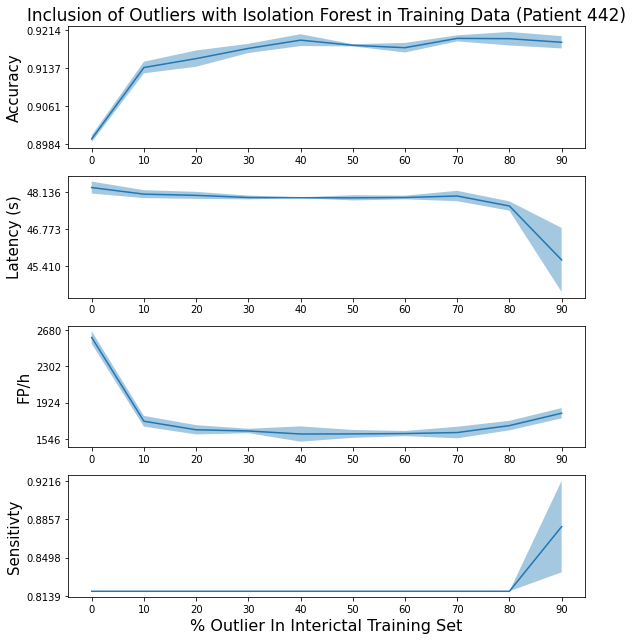

In [ ]:
title='Inclusion of Outliers with Isolation Forest in Training Data (Patient 442)'
plot_metrics(title,f"{RESULT_PATH}Iso_", np.array(["{0:.1f}".format(x) for x in list(np.arange(0.0,0.96,0.10))]), [0,1,2]) #442

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


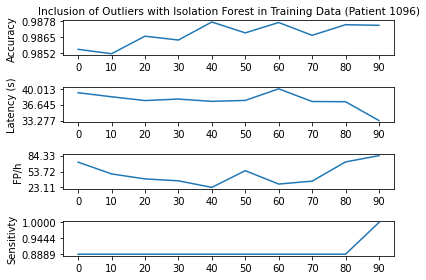

In [ ]:
title='Inclusion of Outliers with Isolation Forest in Training Data (Patient 1096)'
plot_metrics(title,f"drive/My Drive/DATA/1096/LRnew/Iso_", np.array(["{0:.1f}".format(x) for x in list(np.arange(0.0,0.96,0.10))]), [0]) #548 all features

# Testing Sampling Methods (ImbLearn)

In [ ]:
def sample_imblearn(sampler,ii_files, sz_files, i):
    x_train_sz = np.vstack([get_sz(j) for j in leave_out(sz_files, i)])
    x_test_sz = get_sz(i)
    x_nsz = np.vstack([get_fvs(x) for x in ii_files])
    x_train_nsz, x_test_nsz = train_test_split(x_nsz, test_size=x_test_sz.shape[0])
    y = np.concatenate([np.zeros(x_train_nsz.shape[0]), np.ones(x_train_sz.shape[0])])
    X = zscore(np.vstack([x_train_nsz, x_train_sz]))
    X_res, y_res = sampler.fit_resample(X, y)
    return X_res, y_res, zscore(x_test_nsz), zscore(x_test_sz)

In [ ]:
samplers = {'R-DS': RandomUnderSampler()}
clf = LogisticRegression()
test_samplers(clf,samplers, intersz_files, sz_files, "drive/My Drive/DATA/1096/LR/", n_trials=1)

In [ ]:
samplers = {'Near Miss': NearMiss()}
clf = LogisticRegression()
test_samplers(clf,samplers, intersz_files, sz_files, "drive/My Drive/DATA/1096/knn/", n_trials=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Isolation Forest


In [ ]:
# new dataset anomalies 548
from sklearn.ensemble import IsolationForest
X = load_new_ii_dataset(); print(X.shape)
labels = IsolationForest().fit_predict(X)
outlier_idxs = [i for i, label in enumerate(labels) if label == -1]
print(len(outlier_idxs))
np.save(f"{RESULT_PATH}iso_outlier_indices.npy", labels)
np.save(f"{RESULT_PATH}isoforest_outliers.npy",X[outlier_idxs, :])

(695000, 3750)
36657


In [ ]:
# new dataset anomalies 442
from sklearn.ensemble import IsolationFo  
]rest
X = load_new_ii_dataset(); print(X.shape)
labels = IsolationForest().fit_predict(X)
outlier_idxs = [i for i, label in enumerate(labels) if label == -1]
print(len(outlier_idxs))
np.save(f"{RESULT_PATH}iso_outlier_indices.npy", labels)
np.save(f"{RESULT_PATH}isoforest_outliers.npy",X[outlier_idxs, :])

(165000, 3500)
10861


In [ ]:
from sklearn.ensemble import IsolationForest #1096
X = load_new_ii_dataset()
#X_sz = load_sz_dataset()
# X = feature_selection(X_ii, X_sz)
print(X.shape)
labels = IsolationForest().fit_predict(X)
outlier_idxs = [i for i, label in enumerate(labels) if label == -1]
print(len(outlier_idxs))
np.save(f"{RESULT_PATH}iso_outlier_indices.npy", labels)
np.save(f"{RESULT_PATH}isoforest_outliers.npy",X[outlier_idxs, :])

In [ ]:
labels = np.load("iso_outlier_indices.npy")
outliers=[]
for i, fname in enumerate(ii_fnames):
    idxs = [label for label in list(labels[5000*i:5000*(i+1)]) if i == -1]
    outliers.append(np.load(fname)[idxs, :])
    np.save('iso_outliers.npy',np.vstack(outliers))

(array([2.550e+02, 1.500e+01, 3.000e+01, 6.400e+01, 5.600e+01, 1.000e+00,
        3.000e+00, 1.540e+02, 2.700e+01, 1.100e+02, 1.120e+02, 1.800e+01,
        2.500e+02, 1.000e+00, 7.300e+01, 1.360e+02, 1.000e+00, 1.890e+02,
        3.130e+02, 7.600e+01, 1.150e+02, 5.200e+01, 1.000e+00, 2.200e+01,
        1.200e+01, 5.800e+01, 2.170e+02, 2.100e+01, 1.140e+02, 9.400e+01,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.400e+01,
        0.000e+00, 6.100e+01, 3.440e+02, 4.880e+02, 1.335e+03, 3.860e+02,
        1.164e+03, 3.250e+03, 1.505e+03, 3.530e+02, 1.663e+03, 1.479e+03,
        5.920e+02, 1.168e+03, 4.180e+02, 1.980e+02, 7.000e+01, 0.000e+00,
        1.160e+02, 1.110e+02, 5.700e+01, 1.680e+02, 0.000e+00, 1.680e+02,
        9.050e+02, 8.500e+01, 6.190e+02, 6.000e+00, 5.300e+01, 3.160e+02,
        2.340e+02, 1.069e+03, 9.600e+01, 1.800e+01, 8.600e+01, 9.400e+01,
        3.000e+00, 5.520e+02, 4.610e+02, 2.567e+03, 3.510e+02, 2.035e+03,
        3.077e+03, 1.160e+03, 1.270e+0

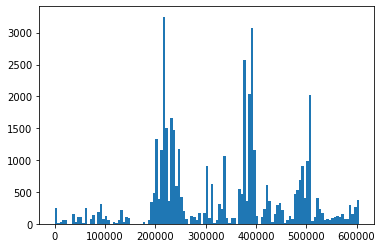

In [ ]:
plt.hist(outlier_idxs, bins=121)

# t-SNE

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
idxs = np.random.choice(500000, size=10000, replace=False)
X_ii=load_ii_dataset()[idxs, :]
print(X_ii.shape)
anom_idxs = np.random.choice(38000, size=10000, replace=False)
X_anom = load_anom(iso=True)[anom_idxs, :]
sz_indices = np.random.choice(27000, size=10000, replace=False)
X_sz = load_sz_dataset()[sz_indices, :]
all_X = np.vstack([X_ii,X_anom,X_sz])
X_pca_50 = zscore(all_X)  #PCA(50).fit_transform(zscore(all_X)); print("Done pca")
X_emb = TSNE(2, verbose=1).fit_transform(X_pca_50); print("Done tsne")

(10000, 2580)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 16.769s...
[t-SNE] Computed neighbors for 30000 samples in 542.291s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional prob

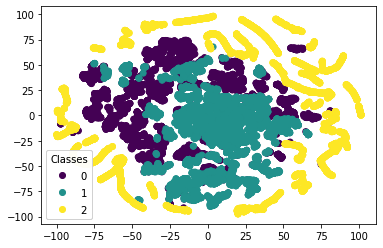

In [ ]:
fig,ax=plt.subplots()
scatter=ax.scatter(X_emb[:, 0], X_emb[:, 1], c=labels)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

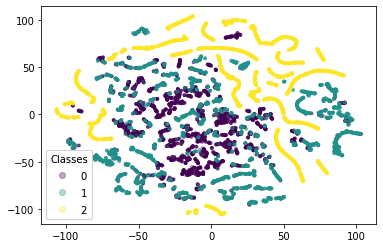

In [ ]:
fig,ax=plt.subplots()
scatter=ax.scatter(X_emb[:, 0], X_emb[:, 1], c=labels, alpha=0.3, s=8)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

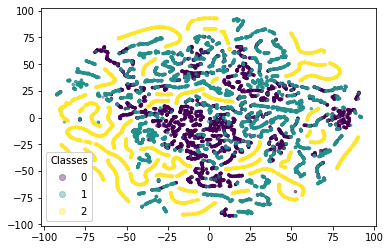

In [ ]:
labels=np.concatenate([np.zeros(10000),np.ones(10000),np.ones(10000)*2])
fig,ax=plt.subplots()
scatter=ax.scatter(X_emb[:, 0], X_emb[:, 1], c=labels, alpha=0.3, s=6)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)